In [1]:
#All the imports
import time
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import multiprocessing
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from sklearn import utils
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import StackingClassifier
from yellowbrick.classifier import ClassificationReport
from yellowbrick.target import ClassBalance

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('vader_lexicon')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\18643\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\18643\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\18643\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\18643\AppData\Roaming\nltk_data...
[nltk_da

True

In [2]:
#Record run time for code to decide on size of data set to use for analysis
StartTime = time.time()

In [3]:
#Read in two very different data frames (Luxury Beauty and Video Games)
LuxuryBeautyDF = pd.read_json('Luxury_Beauty.json', lines=True)
VideoGamesDF = pd.read_json('Video_Games_5.json', lines=True)

In [4]:
#Create binary category columns for Luxury Beauty and Video Games
LuxuryBeautyDF['LuxBea'] = 1
LuxuryBeautyDF['VidGam'] = 0
VideoGamesDF['LuxBea'] = 0
VideoGamesDF['VidGam'] = 1

In [5]:
#Blend both dataframes into one, shuffle rows
#For computational time, limiting to approximately 100,000 reviews
Blend = [LuxuryBeautyDF,VideoGamesDF]
BlendDF = pd.concat(Blend)
BlendDF = BlendDF.sample(frac = 0.1).reset_index()

In [6]:
#Add column with Date from converted Unix time. Unfortunately results does not give time.
BlendDF["Date"] = pd.to_datetime(BlendDF["unixReviewTime"], unit='s')

In [7]:
#Create binary rating column: 0 (negative = 1-2), 1 (positive = 3-5)
#Binning decision came from running tests against validation data
conditions = [
    (BlendDF["overall"] > 2),
    (BlendDF["overall"] < 3)
    ]
values = [1, 0]
BlendDF['BinaryRating'] = np.select(conditions, values)

In [8]:
#Create column of review text with all lowercase, no punctuation, and no stopwords
nan_value = float("NaN") #Create na variable for blanks
BlendDF["reviewText"].replace("", nan_value, inplace=True) #Replace blanks with na variable
BlendDF.dropna(subset = ["reviewText"], inplace=True) #Drop all rows with na review text
BlendDF["ReviewNoFiller"] = BlendDF["reviewText"].str.replace('[^\w\s]','',regex=True) #Create column with review text with no punctuation
BlendDF["ReviewNoFiller"] = BlendDF["ReviewNoFiller"].str.lower() #Make all words lowercase
stopwords = stopwords.words('english') #Create stopwords variable
BlendDF["ReviewNoFiller"] = BlendDF["ReviewNoFiller"].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)])) #Remove stop words
BlendDF["ReviewNoFiller"].replace("", nan_value, inplace=True,regex=True) #Replace blanks with na
BlendDF.dropna(subset = ["ReviewNoFiller"], inplace=True) #Drop all rows with na review text, reset indices
BlendDF = BlendDF.sample(frac = 1).reset_index() #Randomize resulting dataframe and reset indices

In [9]:
#Insert columns with tokenized review and summary
BlendDF["ReviewToken"] = BlendDF.apply(lambda row: word_tokenize(row["ReviewNoFiller"]), axis=1)

In [10]:
#Lemmatize all reviews and summaries, rejoin the strings
WNL = WordNetLemmatizer()
def lemmatize_text(text):
    return [WNL.lemmatize(w) for w in text]
BlendDF['ReviewToken'] = BlendDF.ReviewToken.apply(lemmatize_text)
BlendDF['ReviewLemma'] = BlendDF['ReviewToken'].apply(' '.join)

In [11]:
#Print out distribution of resulting review ratings
print(BlendDF['overall'].value_counts())

5    67963
4    16309
3     9324
1     8110
2     5323
Name: overall, dtype: int64


In [12]:
#Insert column with VADER sentiment analysis compound score of full review text, scale numbers from 1 to 5
vader = SentimentIntensityAnalyzer()
BlendDF["VaderCompound"] = [vader.polarity_scores(x)['compound'] for x in BlendDF['reviewText']]
scaler = MinMaxScaler(feature_range=(1,5))
BlendDF["VaderCompound"] = scaler.fit_transform(BlendDF["VaderCompound"].values.reshape(-1,1))

In [13]:
#Insert column with review word count
BlendDF["WordCount"] = BlendDF["ReviewToken"].apply(len)

count    107029.000000
mean         40.593110
std          85.933559
min           1.000000
25%           5.000000
50%          15.000000
75%          37.000000
max        2993.000000
Name: WordCount, dtype: float64


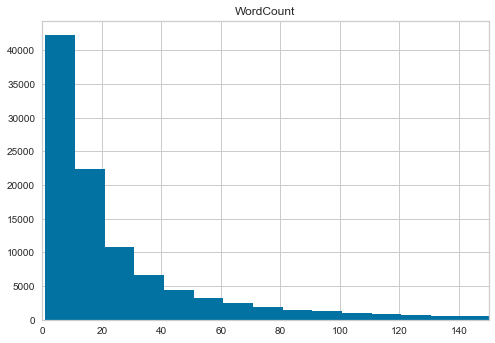

In [14]:
#What does word count distribution look like? Need visualization to decide how to bin data. Also look at descriptive statistics.
WordHist = BlendDF.hist(column = 'WordCount', bins=300)
plt.xlim([0,150])
print(BlendDF["WordCount"].describe()) #25% is 6 or less, 25% is 29 words or more, will bin accordingly

In [15]:
#Create column categorizing review word count as short (1) or not (0)
conditions = [
    (BlendDF["WordCount"] < 7),
    (BlendDF["WordCount"] > 6)
    ]
values = [1,0]
BlendDF['Short'] = np.select(conditions, values)

In [16]:
#Create column categorizing review word count as long (1) or not (0)
conditions = [
    (BlendDF["WordCount"] > 28),
    (BlendDF["WordCount"] < 29)
    ]
values = [1,0]
BlendDF['Long'] = np.select(conditions, values)

In [17]:
#Create column categorizing reviewer as verified (1) or not (0)
conditions = [
    (BlendDF['verified'] == True),
    (BlendDF['verified'] == False)
    ]
values = [1, 0]
BlendDF['Verified'] = np.select(conditions, values)

In [18]:
#Create binary column if the reviewer uploaded an image (1) or did not (0)
conditions = [
    (pd.notnull(BlendDF['image'])),
    (pd.isnull(BlendDF['image']))
    ]
values = [1, 0]
BlendDF['IsImage'] = np.select(conditions, values)

In [19]:
#Adjust vote column to allow for analysis
print(BlendDF.dtypes,'\n')
BlendDF['vote'] = BlendDF['vote'].str.replace('[^\w\s]','',regex=True) #Remove all punctuation from strings
BlendDF['vote'].replace('', '0', inplace=True) #Replace blanks with 0
BlendDF['vote'] = BlendDF['vote'].fillna('0') # Replace na values with 0
BlendDF['vote'] = BlendDF['vote'].astype({'vote': 'int32'})
print(BlendDF.dtypes,'\n')

level_0                    int64
index                      int64
overall                    int64
vote                      object
verified                    bool
reviewTime                object
reviewerID                object
asin                      object
reviewerName              object
reviewText                object
summary                   object
unixReviewTime             int64
style                     object
image                     object
LuxBea                     int64
VidGam                     int64
Date              datetime64[ns]
BinaryRating               int32
ReviewNoFiller            object
ReviewToken               object
ReviewLemma               object
VaderCompound            float64
WordCount                  int64
Short                      int32
Long                       int32
Verified                   int32
IsImage                    int32
dtype: object 

level_0                    int64
index                      int64
overall                    

In [20]:
#Read into five emotions lexicon, convert into five dictionaries
WarrinerWords = pd.read_csv("Warriner_BE.txt", sep='\t')
JoyDict = dict(zip(WarrinerWords.Word, WarrinerWords.Joy))
AngerDict = dict(zip(WarrinerWords.Word, WarrinerWords.Anger))
SadnessDict = dict(zip(WarrinerWords.Word, WarrinerWords.Sadness))
FearDict = dict(zip(WarrinerWords.Word, WarrinerWords.Fear))
DisgustDict = dict(zip(WarrinerWords.Word, WarrinerWords.Disgust))

In [21]:
#Create columns for five emotions, initialize all of them at zero
BlendDF['Joy'] = 0.0
BlendDF['Anger'] = 0.0
BlendDF['Sadness'] = 0.0
BlendDF['Fear'] = 0.0
BlendDF['Disgust'] = 0.0

In [22]:
#Iterate through all lists of words, assigning them scores for all emotions
for index, row in BlendDF.iterrows():
    for word in row['ReviewToken']:
        BlendDF.at[index,'Joy'] += JoyDict.get(word,0)
        BlendDF.at[index,'Anger'] += AngerDict.get(word,0)
        BlendDF.at[index,'Sadness'] += SadnessDict.get(word,0)
        BlendDF.at[index,'Fear'] += FearDict.get(word,0)
        BlendDF.at[index,'Disgust'] += DisgustDict.get(word,0)

In [23]:
#Look at averages of emotions for overall ratings
print(BlendDF.groupby('overall')['Joy'].mean().round(2), "\n",
      BlendDF.groupby('overall')['Anger'].mean().round(2), "\n",
      BlendDF.groupby('overall')['Sadness'].mean().round(2), "\n",
      BlendDF.groupby('overall')['Fear'].mean().round(2), "\n",
      BlendDF.groupby('overall')['Disgust'].mean().round(2), "\n")

overall
1     53.88
2     85.26
3    102.65
4    104.51
5     51.78
Name: Joy, dtype: float64 
 overall
1    32.42
2    50.40
3    59.27
4    58.90
5    27.82
Name: Anger, dtype: float64 
 overall
1    31.70
2    49.31
3    58.03
4    57.70
5    27.39
Name: Sadness, dtype: float64 
 overall
1    32.88
2    51.39
3    60.65
4    60.41
5    28.55
Name: Fear, dtype: float64 
 overall
1    32.12
2    49.50
3    57.82
4    57.25
5    27.11
Name: Disgust, dtype: float64 



In [24]:
#Create data frame for analysis
BlendDF = BlendDF[['ReviewLemma','VaderCompound','Short','Verified','Long','IsImage','WordCount','vote',
                   'LuxBea','VidGam','Joy','Anger','Sadness','Fear','Disgust','overall','BinaryRating']]

#Print some of the dataframe to verify work
pd.set_option('display.max_columns', None) #So as not to truncate output
pd.set_option('display.max_rows', None) #So as not to truncate output
for col in BlendDF.columns: #Print column names
    print(col)
print(BlendDF.head()) # Print first five entries in dataframe
print("The number of rows in the data frame is:", len(BlendDF.index))

ReviewLemma
VaderCompound
Short
Verified
Long
IsImage
WordCount
vote
LuxBea
VidGam
Joy
Anger
Sadness
Fear
Disgust
overall
BinaryRating
                                         ReviewLemma  VaderCompound  Short  \
0                                      real fun game       4.021151      1   
1  using revlon blow drying burshes replace often...       4.884594      0   
2  good game simcity like gimmick needed game gre...       4.614781      0   
3                                    work advertised       2.999900      1   
4    ive tried vitamin c cream serum one really work       3.718936      0   

   Verified  Long  IsImage  WordCount  vote  LuxBea  VidGam         Joy  \
0         1     0        0          3     0       0       1   11.336400   
1         1     1        0         76     2       1       0  124.934099   
2         1     0        0         12     0       0       1   25.048300   
3         1     0        0          2     0       1       0    1.661800   
4         1     0    

In [25]:
# Write final dataframe into csv
BlendDF.to_csv(r'BlendedReviews.csv', index = False)

In [26]:
"""
TF-IDF Approach
First group of models are binary models predicting positive or negative rating
"""

#Implement TF-IDF for binary model
tfidf = TfidfVectorizer(max_features=100000, ngram_range=(1,7), analyzer='char')
X = tfidf.fit_transform(BlendDF['ReviewLemma'])
Y = BlendDF['BinaryRating']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1) #Split into 80/20 train and test sets

#Run binary logistic regression
LR = linear_model.LogisticRegression(solver='lbfgs',max_iter=10000)
LR.fit(X_train, Y_train)

#Look at ability of model to predict test set
LRScore = round((LR.score(X_test, Y_test))*100,2)
print('Binary Logistic Model Score for TF-IDF:',LRScore,'%','\n')
Y_pred = LR.predict(X_test)
print(classification_report(Y_test, Y_pred, zero_division=0), '\n')

#Implement Linear SVC model for binary TF-IDF
LSVC = LinearSVC(C = 10, class_weight='balanced', max_iter=10000)
LSVC.fit(X_train, Y_train)

#Score Linear SVC Model
LSVCScore = round((LSVC.score(X_test, Y_test))*100,2)
print('Binary Linear SVC Model Score for TFIDF is:',LSVCScore,'%', '\n')
Y_pred = LSVC.predict(X_test)
print(classification_report(Y_test, Y_pred, zero_division=0), '\n')

# #Run Binary SVM
# svclassifier = SVC(kernel='linear')
# svclassifier.fit(X_train, Y_train)

# #Look at ability of model to predict test set
# SVMScore = round((svclassifier.score(X_test, Y_test))*100,2)
# print('Binary SVM Score for TF-IDF:',SVMScore,'%','\n')
# Y_pred = svclassifier.predict(X_test)
# print(classification_report(Y_test, Y_pred, zero_division=0), '\n')

#Run K Nearest Neighbors Algorithm
KNN = KNeighborsClassifier(n_neighbors = 5)
KNN.fit(X_train, Y_train)

#Look at ability of model to predict test set
KNNScore = round((KNN.score(X_test, Y_test))*100,2)
print('K Nearest Neighbors Algorithm Model Score for TF-IDF: ',KNNScore,'%','\n')
Y_pred = KNN.predict(X_test)
print(classification_report(Y_test, Y_pred, zero_division=0), '\n')

Binary Logistic Model Score for TF-IDF: 91.48 % 

              precision    recall  f1-score   support

           0       0.81      0.43      0.56      2726
           1       0.92      0.99      0.95     18680

    accuracy                           0.91     21406
   macro avg       0.87      0.71      0.76     21406
weighted avg       0.91      0.91      0.90     21406
 

Binary Linear SVC Model Score for TFIDF is: 89.24 % 

              precision    recall  f1-score   support

           0       0.57      0.65      0.61      2726
           1       0.95      0.93      0.94     18680

    accuracy                           0.89     21406
   macro avg       0.76      0.79      0.77     21406
weighted avg       0.90      0.89      0.90     21406
 

K Nearest Neighbors Algorithm Model Score for TF-IDF:  88.32 % 

              precision    recall  f1-score   support

           0       0.67      0.17      0.27      2726
           1       0.89      0.99      0.94     18680

    accur

TF-IDF Binary Class Balance



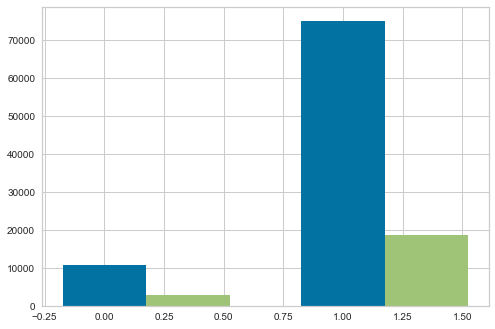

TF-IDF Binary Logistics Regression



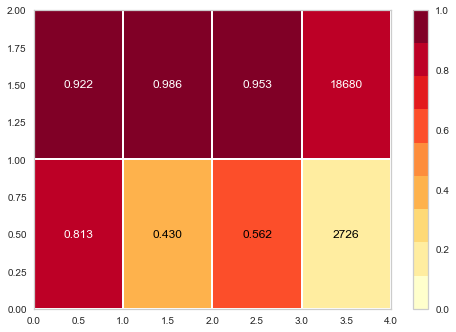

TF-IDF Binary SVM



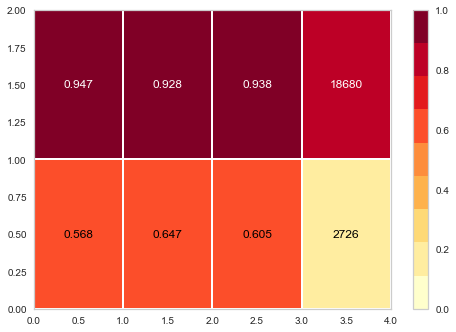

TF-IDF Binary KNN



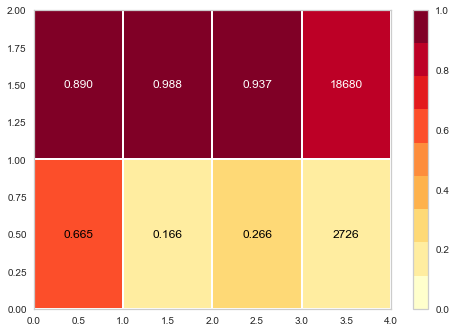

In [27]:
"""
TF-IDF Visualizations for binary models
"""

#Class Balance Visualization
CB = ClassBalance()
CB.fit(Y_train, Y_test)
print('TF-IDF Binary Class Balance\n')
plt.show()

#Classification Report for Logistics Regression
LRC = ClassificationReport(LR, support=True)
LRC.fit(X_train, Y_train)      
LRC.score(X_test, Y_test)
print('TF-IDF Binary Logistics Regression\n')
plt.show() 

#Classification Report for SVM
SVMC = ClassificationReport(LSVC, support=True)
SVMC.fit(X_train, Y_train)      
SVMC.score(X_test, Y_test)
print('TF-IDF Binary SVM\n')
plt.show() 

#Classification Report for KNN
KNNC = ClassificationReport(KNN, support=True)
KNNC.fit(X_train, Y_train)      
KNNC.score(X_test, Y_test)
print('TF-IDF Binary KNN\n')
plt.show() 

In [28]:
"""
TF-IDF Approach
Second group of models are multiclass models for 1-5 rating
"""
#Implement TF-IDF for multiclass model
tfidf = TfidfVectorizer(max_features=100000, ngram_range=(1,7), analyzer='char')
X = tfidf.fit_transform(BlendDF['ReviewLemma'])
Y = BlendDF['overall']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1) #Split into 80/20 train and test sets

#Run multinomial logistic regression
MLR = linear_model.LogisticRegression(multi_class='multinomial', solver='lbfgs',max_iter=10000)
MLR.fit(X_train, Y_train)

#Look at ability of model to predict test set
MLRScore = round((MLR.score(X_test, Y_test))*100,2)
print('Multinomial Logistic Model Score for TF-IDF: ',MLRScore,'%','\n')
Y_pred = MLR.predict(X_test)
print(classification_report(Y_test, Y_pred, zero_division=0), '\n')

#Implement Linear SVC model for TF-IDF multiclass
LSVC = LinearSVC(C = 10, class_weight='balanced', max_iter=10000)
LSVC.fit(X_train, Y_train)

#Score Linear SVC Model
LSVCScore = round((LSVC.score(X_test, Y_test))*100,2)
print('Multiclass Linear SVC Model Score for TFIDF is:',LSVCScore,'%', '\n')
Y_pred = LSVC.predict(X_test)
print(classification_report(Y_test, Y_pred, zero_division=0), '\n')

# #Run Multiclass SVM
# msvclassifier = SVC(kernel='linear')
# msvclassifier.fit(X_train, Y_train)

# #Look at ability of model to predict test set
# MSVMScore = round((msvclassifier.score(X_test, Y_test))*100,2)
# print('Multiclass SVM Score is for TF-IDF: ',MSVMScore,'%','\n')
# Y_pred = msvclassifier.predict(X_test)
# print(classification_report(Y_test, Y_pred, zero_division=0), '\n')

#Run K Nearest Neighbors Algorithm
KNN = KNeighborsClassifier(n_neighbors = 15)
KNN.fit(X_train, Y_train)

#Look at ability of model to predict test set
KNNScore = round((KNN.score(X_test, Y_test))*100,2)
print('K Nearest Neighbors Algorithm Model Score for TF-IDF: ',KNNScore,'%','\n')
Y_pred = KNN.predict(X_test)
print(classification_report(Y_test, Y_pred, zero_division=0), '\n')

Multinomial Logistic Model Score for TF-IDF:  70.34 % 

              precision    recall  f1-score   support

           1       0.62      0.55      0.59      1675
           2       0.41      0.07      0.12      1051
           3       0.44      0.23      0.30      1907
           4       0.44      0.22      0.29      3263
           5       0.75      0.96      0.84     13510

    accuracy                           0.70     21406
   macro avg       0.53      0.41      0.43     21406
weighted avg       0.65      0.70      0.65     21406
 

Multiclass Linear SVC Model Score for TFIDF is: 64.26 % 

              precision    recall  f1-score   support

           1       0.51      0.52      0.51      1675
           2       0.24      0.24      0.24      1051
           3       0.29      0.31      0.30      1907
           4       0.32      0.31      0.32      3263
           5       0.82      0.82      0.82     13510

    accuracy                           0.64     21406
   macro avg   

TF-IDF Multiclass Class Balance



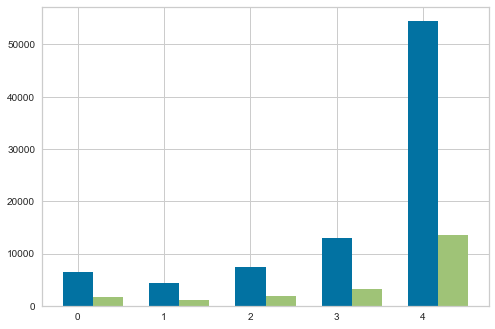

TF-IDF Multiclass Logistics Regression



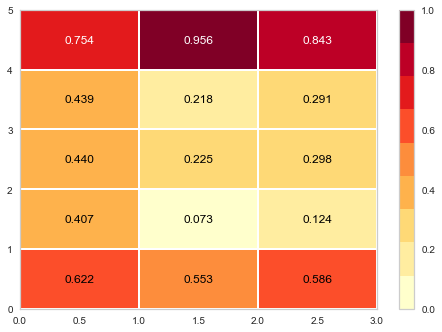

TF-IDF Multiclass SVM



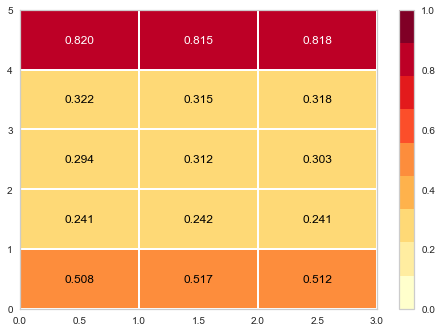

TF-IDF Multiclass KNN



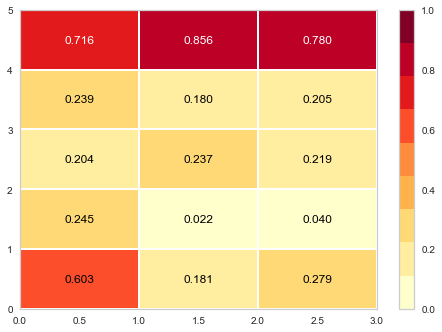

In [29]:
"""
TF-IDF Visualizations for multiclass models
"""

#Class Balance Visualization
CB = ClassBalance()
CB.fit(Y_train, Y_test)
print('TF-IDF Multiclass Class Balance\n')
plt.show()

#Classification Report for Logistics Regression
MLRC = ClassificationReport(MLR, support=False)
MLRC.fit(X_train, Y_train)      
MLRC.score(X_test, Y_test)
print('TF-IDF Multiclass Logistics Regression\n')
plt.show() 

#Classification Report for SVM
SVMC = ClassificationReport(LSVC, support=False)
SVMC.fit(X_train, Y_train)      
SVMC.score(X_test, Y_test)
print('TF-IDF Multiclass SVM\n')
plt.show() 

#Classification Report for KNN
KNNC = ClassificationReport(KNN, support=False)
KNNC.fit(X_train, Y_train)      
KNNC.score(X_test, Y_test)
print('TF-IDF Multiclass KNN\n')
plt.show() 

In [30]:
"""
Doc2Vec Approach
First group of models are binary models predicting positive or negative rating
"""

#Split into 80/20 train and test 
X = BlendDF['ReviewLemma']
Y = BlendDF['BinaryRating']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

#Function to label reviews train or test
def label_reviews(review, label_type):
    labeled = []
    for i,v in enumerate(review):
        label = label_type + '_' + str(i)
        labeled.append(TaggedDocument(v.split(), [label]))
    return labeled

#Label training and test sets using function
X_train = label_reviews(X_train, 'Train')
X_test = label_reviews(X_test,'Test')
AllData = X_train + X_test

#Build BOW Doc2Vec model
DBOWModel = Doc2Vec(dm=0, vector_size=300, negative=5, min_count=1, alpha=0.065, min_alpha=0.065)
DBOWModel.build_vocab([x for x in AllData])

#Iterate over data to train model
for epoch in range(30):
    DBOWModel.train(utils.shuffle([x for x in AllData]), total_examples=len(AllData), epochs=1)
    DBOWModel.alpha -= 0.002
    DBOWModel.min_alpha = DBOWModel.alpha

#Create function to vectorize all reviews
def get_vectors(model, corpus_size, vectors_size, vectors_type):
    vectors = np.zeros((corpus_size, vectors_size))
    for i in range(0, corpus_size):
        prefix = vectors_type + '_' + str(i)
        vectors[i] = model.docvecs[prefix]
    return vectors

#Vectorize training and testing data
train_vectors_dbow = get_vectors(DBOWModel, len(X_train), 300, 'Train')
test_vectors_dbow = get_vectors(DBOWModel, len(X_test), 300, 'Test')

#Run binary logistic regression
LR = linear_model.LogisticRegression(solver='lbfgs',max_iter=10000)
LR = LR.fit(train_vectors_dbow, Y_train)

#Look at ability of model to predict test set
LRScore = round((LR.score(test_vectors_dbow, Y_test))*100,2)
print('Binary Logistic Model Score for Doc2Vec:',LRScore,'%','\n')
Y_pred = LR.predict(test_vectors_dbow)
print(classification_report(Y_test, Y_pred, zero_division=0), '\n')

#Run Binary SVM
svclassifier = SVC(kernel='linear')
svclassifier.fit(train_vectors_dbow, Y_train)

#Look at ability of model to predict test set
SVMScore = round((svclassifier.score(test_vectors_dbow, Y_test))*100,2)
print('Binary SVM Score for Doc2Vec is:',SVMScore,'%','\n')
Y_pred = svclassifier.predict(test_vectors_dbow)
print(classification_report(Y_test, Y_pred, zero_division=0), '\n')

#Run K Nearest Neighbors Algorithm
KNN = KNeighborsClassifier(n_neighbors = 5)
KNN.fit(train_vectors_dbow, Y_train)

#Look at ability of model to predict test set
KNNScore = round((KNN.score(test_vectors_dbow, Y_test))*100,2)
print('K Nearest Neighbors Algorithm Model Score for Doc2Vec: ',KNNScore,'%','\n')
Y_pred = KNN.predict(test_vectors_dbow)
print(classification_report(Y_test, Y_pred, zero_division=0), '\n')

C:\Users\18643\AppData\Local\Temp/ipykernel_13960/2799700782.py:39: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  vectors[i] = model.docvecs[prefix]


Binary Logistic Model Score for Doc2Vec: 90.47 % 

              precision    recall  f1-score   support

           0       0.71      0.43      0.53      2726
           1       0.92      0.97      0.95     18680

    accuracy                           0.90     21406
   macro avg       0.82      0.70      0.74     21406
weighted avg       0.89      0.90      0.89     21406
 

Binary SVM Score for Doc2Vec is: 90.45 % 

              precision    recall  f1-score   support

           0       0.75      0.38      0.50      2726
           1       0.92      0.98      0.95     18680

    accuracy                           0.90     21406
   macro avg       0.83      0.68      0.72     21406
weighted avg       0.89      0.90      0.89     21406
 

K Nearest Neighbors Algorithm Model Score for Doc2Vec:  89.33 % 

              precision    recall  f1-score   support

           0       0.67      0.32      0.43      2726
           1       0.91      0.98      0.94     18680

    accuracy      

Doc2Vec Binary Class Balance



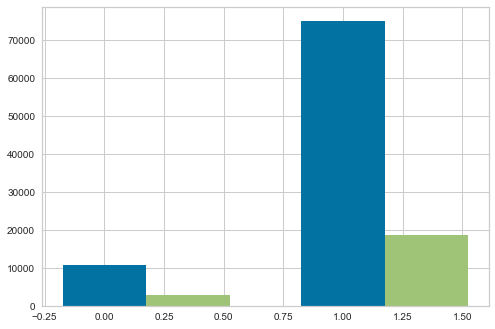

Doc2Vec Binary Logistics Regression



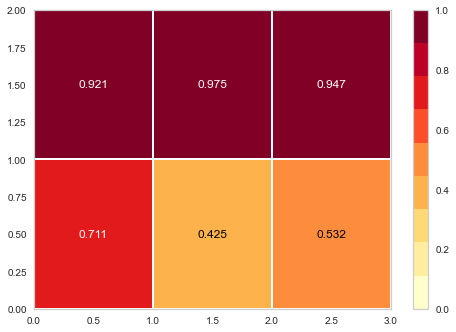

Doc2Vec Binary SVM



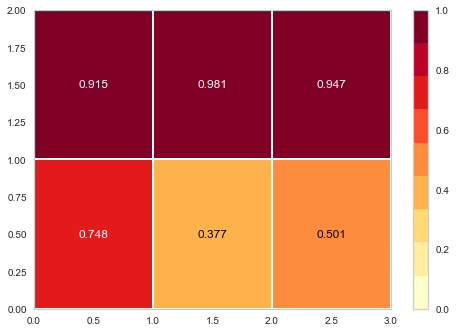

Doc2Vec Binary KNN



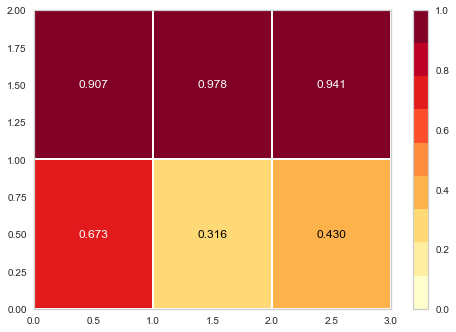

In [31]:
"""
Doc2Vec Visualizations for binary models
"""

#Class Balance Visualization
CB = ClassBalance()
CB.fit(Y_train, Y_test)
print('Doc2Vec Binary Class Balance\n')
plt.show()

#Classification Report for Logistics Regression
LRC = ClassificationReport(LR, support=False)
LRC.fit(train_vectors_dbow, Y_train)      
LRC.score(test_vectors_dbow, Y_test)
print('Doc2Vec Binary Logistics Regression\n')
plt.show() 

#Classification Report for SVM
SVMC = ClassificationReport(svclassifier, support=False)
SVMC.fit(train_vectors_dbow, Y_train)      
SVMC.score(test_vectors_dbow, Y_test)
print('Doc2Vec Binary SVM\n')
plt.show() 

#Classification Report for KNN
KNNC = ClassificationReport(KNN, support=False)
KNNC.fit(train_vectors_dbow, Y_train)      
KNNC.score(test_vectors_dbow, Y_test)
print('Doc2Vec Binary KNN\n')
plt.show() 

In [32]:
"""
Doc2Vec Approach
Second group of models are multiclass models for 1-5 rating
"""

#Split into 80/20 train and test 
X = BlendDF['ReviewLemma']
Y = BlendDF['overall']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

#Label training and test sets using function
X_train = label_reviews(X_train, 'Train')
X_test = label_reviews(X_test,'Test')
AllData = X_train + X_test

#Build Doc2Vec model
DBOWModel = Doc2Vec(dm=0, vector_size=300, negative=5, min_count=1, alpha=0.065, min_alpha=0.065)
DBOWModel.build_vocab([x for x in AllData])

#Iterate over data to train model
for epoch in range(30):
    DBOWModel.train(utils.shuffle([x for x in AllData]), total_examples=len(AllData), epochs=1)
    DBOWModel.alpha -= 0.002
    DBOWModel.min_alpha = DBOWModel.alpha

#Vectorize training and testing data
train_vectors_dbow = get_vectors(DBOWModel, len(X_train), 300, 'Train')
test_vectors_dbow = get_vectors(DBOWModel, len(X_test), 300, 'Test')

#Run multinomial logistic regression
MLR = linear_model.LogisticRegression(multi_class='multinomial', solver='lbfgs',max_iter=10000)
MLR.fit(train_vectors_dbow, Y_train)

#Look at ability of model to predict test set
MLRScore = round((MLR.score(test_vectors_dbow, Y_test))*100,2)
print('Multinomial Logistic Model Score for Doc2Vec: ',MLRScore,'%','\n')
Y_pred = MLR.predict(test_vectors_dbow)
print(classification_report(Y_test, Y_pred, zero_division=0), '\n')

#Run Multiclass SVM
msvclassifier = SVC(kernel='linear')
msvclassifier.fit(train_vectors_dbow, Y_train)

#Look at ability of model to predict test set
MSVMScore = round((msvclassifier.score(test_vectors_dbow, Y_test))*100,2)
print('Multiclass SVM Score is for Doc2Vec: ',MSVMScore,'%','\n')
Y_pred = msvclassifier.predict(test_vectors_dbow)
print(classification_report(Y_test, Y_pred, zero_division=0), '\n')

#Run K Nearest Neighbors Algorithm
KNN = KNeighborsClassifier(n_neighbors = 15)
KNN.fit(train_vectors_dbow, Y_train)

#Look at ability of model to predict test set
KNNScore = round((KNN.score(test_vectors_dbow, Y_test))*100,2)
print('K Nearest Neighbors Algorithm Model Score for Doc2Vec: ',KNNScore,'%','\n')
Y_pred = KNN.predict(test_vectors_dbow)
print(classification_report(Y_test, Y_pred, zero_division=0), '\n')

C:\Users\18643\AppData\Local\Temp/ipykernel_13960/2799700782.py:39: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  vectors[i] = model.docvecs[prefix]


Multinomial Logistic Model Score for Doc2Vec:  68.33 % 

              precision    recall  f1-score   support

           1       0.55      0.51      0.53      1675
           2       0.30      0.08      0.12      1051
           3       0.35      0.17      0.23      1907
           4       0.43      0.18      0.26      3263
           5       0.74      0.94      0.83     13510

    accuracy                           0.68     21406
   macro avg       0.48      0.38      0.40     21406
weighted avg       0.62      0.68      0.63     21406
 

Multiclass SVM Score is for Doc2Vec:  67.7 % 

              precision    recall  f1-score   support

           1       0.56      0.51      0.54      1675
           2       0.31      0.07      0.12      1051
           3       0.34      0.19      0.24      1907
           4       0.33      0.00      0.00      3263
           5       0.71      0.98      0.82     13510

    accuracy                           0.68     21406
   macro avg       0.45  

Doc2Vec Multiclass Class Balance



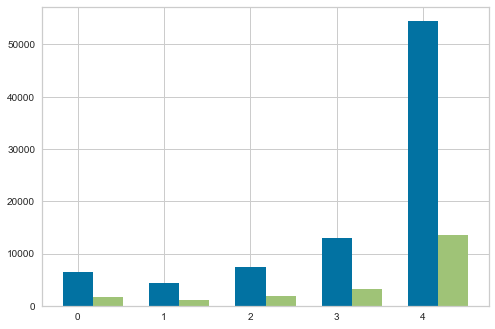

Doc2Vec Multiclass Logistics Regression



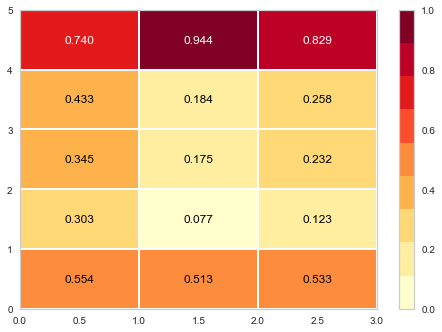

Doc2Vec Multiclass SVM



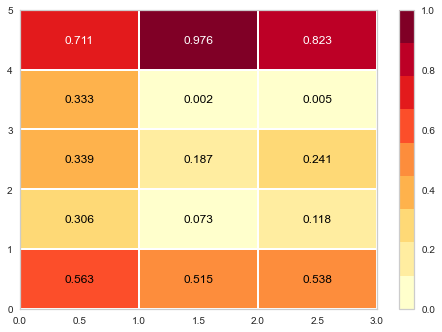

KNN Multiclass Logistics Regression



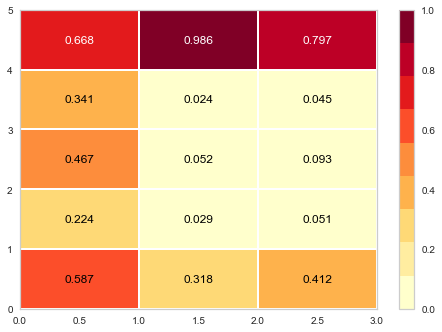

In [33]:
"""
Doc2Vec Visualizations for multiclass models
"""

#Class Balance Visualization
CB = ClassBalance()
CB.fit(Y_train, Y_test)
print('Doc2Vec Multiclass Class Balance\n')
plt.show()

#Classification Report for Logistics Regression
MLRC = ClassificationReport(MLR, support=False)
MLRC.fit(train_vectors_dbow, Y_train)      
MLRC.score(test_vectors_dbow, Y_test)
print('Doc2Vec Multiclass Logistics Regression\n')
plt.show() 

#Classification Report for SVM
SVMC = ClassificationReport(msvclassifier, support=False)
SVMC.fit(train_vectors_dbow, Y_train)      
SVMC.score(test_vectors_dbow, Y_test)
print('Doc2Vec Multiclass SVM\n')
plt.show() 

#Classification Report for KNN
KNNC = ClassificationReport(KNN, support=False)
KNNC.fit(train_vectors_dbow, Y_train)      
KNNC.score(test_vectors_dbow, Y_test)
print('KNN Multiclass Logistics Regression\n')
plt.show() 

In [34]:
"""
VADER Score
First group of models are binary models predicting positive or negative rating
"""

#Split data into training and test sets with a 80/20 split for all binary models
X = BlendDF[['VaderCompound','Short','Verified','Long','IsImage']] #set independent variables for regression
Y = BlendDF['BinaryRating'] #set dependent variable for regression
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1) #Split into 80/20 train and test sets

#Run binary logistic regression
LR = linear_model.LogisticRegression(solver='lbfgs',max_iter=10000)
LR.fit(X_train, Y_train)
print('Binary Logistic Intercept is:', LR.intercept_, '\n')
print('Binary Logistic Coefficients are:', LR.coef_, '\n')

#Look at ability of model to predict test set
LRScore = round((LR.score(X_test, Y_test))*100,2)
print('Binary Logistic Model Score for VADER Score:',LRScore,'%','\n')
Y_pred = LR.predict(X_test)
print(classification_report(Y_test, Y_pred, zero_division=0), '\n')

#Run Binary SVM
svclassifier = SVC(kernel='linear')
svclassifier.fit(X_train, Y_train)

#Look at ability of model to predict test set
SVMScore = round((svclassifier.score(X_test, Y_test))*100,2)
print('Binary SVM Score for VADER Score:',SVMScore,'%','\n')
Y_pred = svclassifier.predict(X_test)
print(classification_report(Y_test, Y_pred, zero_division=0), '\n')

#Run Naive Bayes Classifier
NB = GaussianNB()
NB.fit(X_train, Y_train)

#Look at ability of model to predict test set
NBScore = round((NB.score(X_test, Y_test))*100,2)
print('Binary Naive Bayes Classifier Score for VADER Score:',NBScore,'%','\n')
Y_pred = NB.predict(X_test)
print(classification_report(Y_test, Y_pred, zero_division=0), '\n')

#Implement stacked ensemble model
Estimators = [('NB',NB), ('SVM',svclassifier)]
StackedModel = StackingClassifier (estimators = Estimators, final_estimator = linear_model.LogisticRegression(solver='lbfgs',max_iter=10000))
StackedModel.fit(X_train, Y_train)

#Look at ability of stacked ensemble model to predict test set
StackScore = round((StackedModel.score(X_test, Y_test))*100,2)
print('Stacked ensemble model score for VADER Score: ',StackScore,'%','\n')
Y_pred = StackedModel.predict(X_test)
print(classification_report(Y_test, Y_pred, zero_division=0), '\n')

Binary Logistic Intercept is: [-2.26851273] 

Binary Logistic Coefficients are: [[ 1.04529659  0.70326823  0.25431971 -0.13515373 -0.77748929]] 

Binary Logistic Model Score for VADER Score: 87.63 % 

              precision    recall  f1-score   support

           0       0.53      0.25      0.34      2726
           1       0.90      0.97      0.93     18680

    accuracy                           0.88     21406
   macro avg       0.71      0.61      0.63     21406
weighted avg       0.85      0.88      0.86     21406
 

Binary SVM Score for VADER Score: 87.27 % 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2726
           1       0.87      1.00      0.93     18680

    accuracy                           0.87     21406
   macro avg       0.44      0.50      0.47     21406
weighted avg       0.76      0.87      0.81     21406
 

Binary Naive Bayes Classifier Score for VADER Score: 87.14 % 

              precision    recall 

VADER Score Binary Class Balance



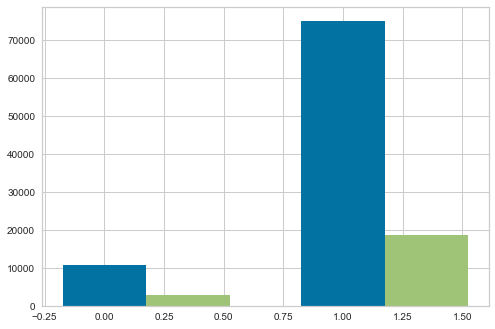

VADER Score Binary Logistics Regression



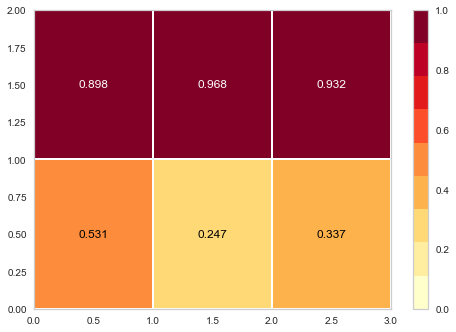

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


VADER Score Binary SVM



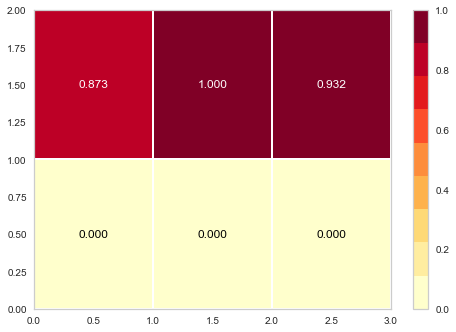

VADER Score Binary Naive Bayes



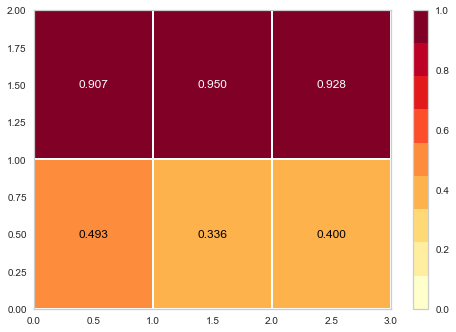

VADER Score Binary Stacked Ensemble



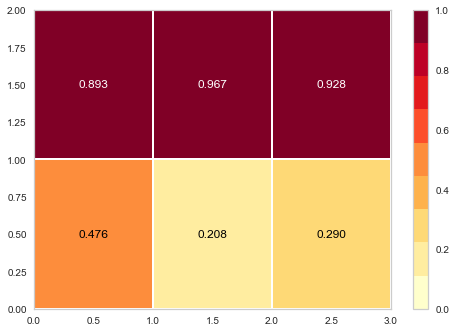

In [35]:
"""
VADER Score Visualizations for binary models
"""

#Class Balance Visualization
CB = ClassBalance()
CB.fit(Y_train, Y_test)
print('VADER Score Binary Class Balance\n')
plt.show()

#Classification Report for Logistics Regression
LRC = ClassificationReport(LR, support=False)
LRC.fit(X_train, Y_train)      
LRC.score(X_test, Y_test)
print('VADER Score Binary Logistics Regression\n')
plt.show() 

#Classification Report for SVM
SVMC = ClassificationReport(svclassifier, support=False)
SVMC.fit(X_train, Y_train)      
SVMC.score(X_test, Y_test)
print('VADER Score Binary SVM\n')
plt.show() 

#Classification Report for Naive Bayes
NBC = ClassificationReport(NB, support=False)
NBC.fit(X_train, Y_train)      
NBC.score(X_test, Y_test)
print('VADER Score Binary Naive Bayes\n')
plt.show()

#Classification Report for Stacked Ensemble Model
StackedC = ClassificationReport(StackedModel, support=False)
StackedC.fit(X_train, Y_train)      
StackedC.score(X_test, Y_test)
print('VADER Score Binary Stacked Ensemble\n')
plt.show()

In [36]:
"""
VADER Score
Second group of models are multiclass models for 1-5 rating
"""
#Split data into training and test sets with a 80/20 split for multiclass models
X = BlendDF[['VaderCompound','Short','Verified','Long','IsImage']] #set independent variables for regression
Y = BlendDF['overall'] #set dependent variable for regression
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1) #Split into 80/20 train and test sets

#Run multinomial logistic regression
MLR = linear_model.LogisticRegression(multi_class='multinomial', solver='lbfgs',max_iter=10000)
MLR.fit(X_train, Y_train)

#Look at ability of model to predict test set
MLRScore = round((MLR.score(X_test, Y_test))*100,2)
print('Multinomial Logistic Model Score for VADER Score: ',MLRScore,'%','\n')
Y_pred = MLR.predict(X_test)
print(classification_report(Y_test, Y_pred, zero_division=0), '\n')

#Run Multiclass SVM
msvclassifier = SVC(kernel='linear')
msvclassifier.fit(X_train, Y_train)

#Look at ability of model to predict test set
MSVMScore = round((msvclassifier.score(X_test, Y_test))*100,2)
print('Multiclass SVM Score is for VADER Score: ',MSVMScore,'%','\n')
Y_pred = msvclassifier.predict(X_test)
print(classification_report(Y_test, Y_pred, zero_division=0), '\n')

#Run K Nearest Neighbors Algorithm
KNN = KNeighborsClassifier(n_neighbors = 15)
KNN.fit(X_train, Y_train)

#Look at ability of model to predict test set
KNNScore = round((KNN.score(X_test, Y_test))*100,2)
print('K Nearest Neighbors Algorithm Model Score for VADER Score: ',KNNScore,'%','\n')
Y_pred = KNN.predict(X_test)
print(classification_report(Y_test, Y_pred, zero_division=0), '\n')

#Run Random Forest Algorithm
RF = RandomForestClassifier(n_estimators=5, random_state=0)
RF.fit(X_train, Y_train)

#Look at ability of model to predict test set
RFScore = round((RF.score(X_test, Y_test))*100,2)
print('Random Forest Classifier Model Score for VADER Score: ',RFScore,'%','\n')
Y_pred = RF.predict(X_test)
print(classification_report(Y_test, Y_pred, zero_division=0), '\n')

#Implement stacked ensemble model
Estimators = [('KNN',KNN), ('SVM',msvclassifier)]
StackedModel = StackingClassifier (estimators = Estimators, final_estimator = linear_model.LogisticRegression(multi_class='multinomial', solver='lbfgs',max_iter=10000))
StackedModel.fit(X_train, Y_train)

#Look at ability of stacked ensemble model to predict test set
StackScore = round((StackedModel.score(X_test, Y_test))*100,2)
print('Stacked ensemble model score for VADER Score: ',StackScore,'%','\n')
Y_pred = StackedModel.predict(X_test)
print(classification_report(Y_test, Y_pred, zero_division=0), '\n')

Multinomial Logistic Model Score for VADER Score:  64.61 % 

              precision    recall  f1-score   support

           1       0.37      0.39      0.38      1675
           2       0.00      0.00      0.00      1051
           3       0.18      0.01      0.02      1907
           4       0.29      0.00      0.01      3263
           5       0.67      0.97      0.80     13510

    accuracy                           0.65     21406
   macro avg       0.30      0.28      0.24     21406
weighted avg       0.51      0.65      0.54     21406
 

Multiclass SVM Score is for VADER Score:  64.4 % 

              precision    recall  f1-score   support

           1       0.36      0.35      0.36      1675
           2       0.00      0.00      0.00      1051
           3       0.00      0.00      0.00      1907
           4       0.00      0.00      0.00      3263
           5       0.67      0.98      0.79     13510

    accuracy                           0.64     21406
   macro avg     

VADER Score Multiclass Class Balance



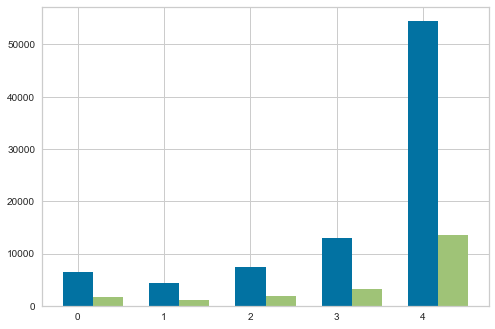

VADER Score Multiclass Logistics Regression



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


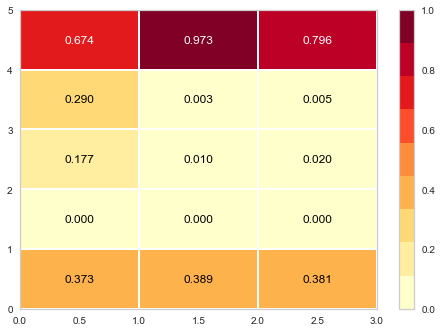

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


VADER Score Multiclass SVM



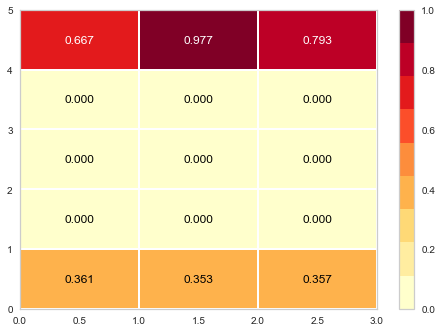

VADER Score Multiclass KNN



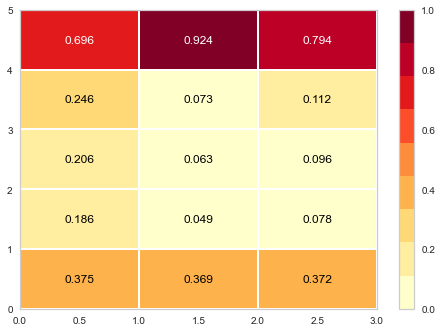

VADER Score Multiclass Random Forest



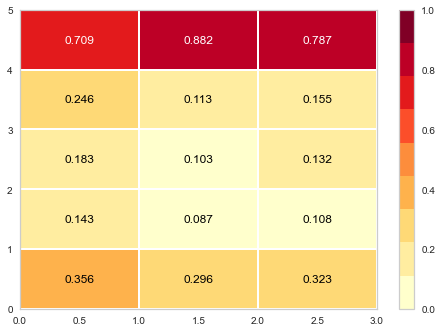

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


VADER Score Multiclass Stacked Ensemble



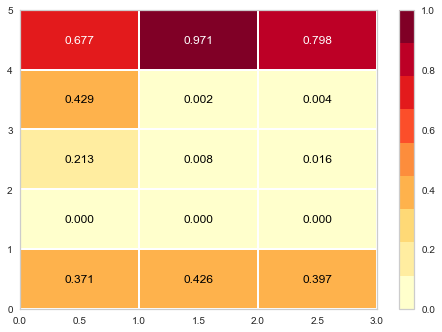

In [37]:
"""
VADER Score Visualizations for multiclass models
"""

#Class Balance Visualization
CB = ClassBalance()
CB.fit(Y_train, Y_test)
print('VADER Score Multiclass Class Balance\n')
plt.show()

#Classification Report for Logistics Regression
MLRC = ClassificationReport(MLR, support=False)
MLRC.fit(X_train, Y_train)      
MLRC.score(X_test, Y_test)
print('VADER Score Multiclass Logistics Regression\n')
plt.show() 

#Classification Report for SVM
SVMC = ClassificationReport(msvclassifier, support=False)
SVMC.fit(X_train, Y_train)      
SVMC.score(X_test, Y_test)
print('VADER Score Multiclass SVM\n')
plt.show() 

#Classification Report for KNN
KNNC = ClassificationReport(KNN, support=False)
KNNC.fit(X_train, Y_train)      
KNNC.score(X_test, Y_test)
print('VADER Score Multiclass KNN\n')
plt.show()

#Classification Report for Random Forest
RFC = ClassificationReport(RF, support=False)
RFC.fit(X_train, Y_train)      
RFC.score(X_test, Y_test)
print('VADER Score Multiclass Random Forest\n')
plt.show() 

#Classification Report for Stacked Ensemble Model
StackedC = ClassificationReport(StackedModel, support=False)
StackedC.fit(X_train, Y_train)      
StackedC.score(X_test, Y_test)
print('VADER Score Multiclass Stacked Ensemble\n')
plt.show()

In [38]:
"""
Five Emotions Approach and other variables approach
First group of models are binary models predicting positive or negative rating
SVM Models have been excluded due to high number of continuous variables makes processing power/time overwhelming
"""

#Split data into training and test sets with a 80/20 split for all binary models
#Based on the very low coefficients for both WordCount and vote, these variables were left out of the models.
X = BlendDF[['Joy','Anger','Sadness','Fear','Disgust','Short','Verified','Long','IsImage']] #set independent variables for regression
Y = BlendDF['BinaryRating'] #set dependent variable for regression
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1) #Split into 80/20 train and test sets

#Run Naive Bayes Classifier
NB = GaussianNB()
NB.fit(X_train, Y_train)

#Look at ability of model to predict test set
NBScore = round((NB.score(X_test, Y_test))*100,2)
print('Naive Bayes Classifier Score is for Five Emotions Model: ',NBScore,'%','\n')
Y_pred = NB.predict(X_test)
print(classification_report(Y_test, Y_pred, zero_division=0), '\n')

#Run binary logistic regression
LR = linear_model.LogisticRegression(solver='lbfgs',max_iter=10000)
LR.fit(X_train, Y_train)

#Look at ability of model to predict test set
LRScore = round((LR.score(X_test, Y_test))*100,2)
print('Binary Logistic Model Score for Five Emotions Model: ',LRScore,'%','\n')
Y_pred = LR.predict(X_test)
print(classification_report(Y_test, Y_pred, zero_division=0), '\n')

Naive Bayes Classifier Score is for Five Emotions Model:  86.72 % 

              precision    recall  f1-score   support

           0       0.22      0.02      0.03      2726
           1       0.87      0.99      0.93     18680

    accuracy                           0.87     21406
   macro avg       0.54      0.50      0.48     21406
weighted avg       0.79      0.87      0.81     21406
 

Binary Logistic Model Score for Five Emotions Model:  87.14 % 

              precision    recall  f1-score   support

           0       0.44      0.03      0.06      2726
           1       0.88      0.99      0.93     18680

    accuracy                           0.87     21406
   macro avg       0.66      0.51      0.50     21406
weighted avg       0.82      0.87      0.82     21406
 



Five Emotions Binary Class Balance



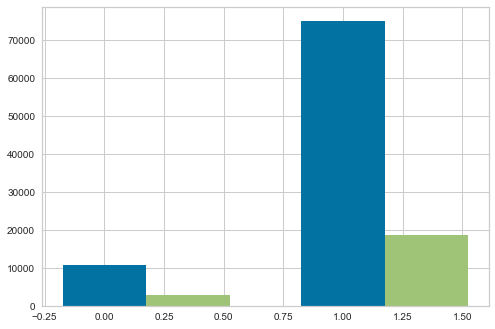

Five Emotions Binary Logistics Regression



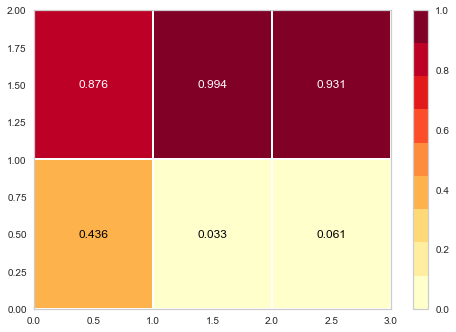

Five Emotions Binary Naive Bayes



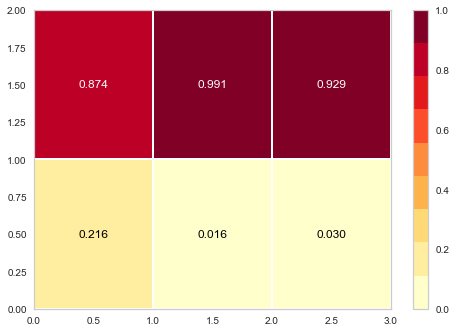

In [39]:
"""
Five Emotions Visualizations for binary models
"""

#Class Balance Visualization
CB = ClassBalance()
CB.fit(Y_train, Y_test)
print('Five Emotions Binary Class Balance\n')
plt.show()

#Classification Report for Logistics Regression
LRC = ClassificationReport(LR, support=False)
LRC.fit(X_train, Y_train)      
LRC.score(X_test, Y_test)
print('Five Emotions Binary Logistics Regression\n')
plt.show() 

#Classification Report for Naive Bayes
NBC = ClassificationReport(NB, support=False)
NBC.fit(X_train, Y_train)      
NBC.score(X_test, Y_test)
print('Five Emotions Binary Naive Bayes\n')
plt.show() 

In [40]:
"""
Five Emotions Approach and other variables approach
Second group of models are multiclass models for 1-5 rating
SVM Models have been excluded due to high number of continuous variables makes processing power/time overwhelming
"""

#Split data into training and test sets with a 80/20 split for multiclass models
#Based on the very low coefficients for both WordCount, vote and categories, these variables were left out of the models.
X = BlendDF[['Joy','Anger','Sadness','Fear','Disgust','Short','Verified','Long','IsImage']] #set independent variables for regression
Y = BlendDF['overall'] #set dependent variable for regression
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1) #Split into 80/20 train and test sets

#Run multinomial logistic regression
MLR = linear_model.LogisticRegression(multi_class='multinomial', solver='lbfgs',max_iter=10000)
MLR.fit(X_train, Y_train)

#Look at ability of model to predict test set
MLRScore = round((MLR.score(X_test, Y_test))*100,2)
print('Multinomial Logistic Model Score for Five Emotions Model: ',MLRScore,'%','\n')
Y_pred = MLR.predict(X_test)
print(classification_report(Y_test, Y_pred, zero_division=0), '\n')

#Run K Nearest Neighbors Algorithm
KNN = KNeighborsClassifier(n_neighbors = 15)
KNN.fit(X_train, Y_train)

#Look at ability of model to predict test set
KNNScore = round((KNN.score(X_test, Y_test))*100,2)
print('K Nearest Neighbors Algorithm Model Score for Five Emotions Model: ',KNNScore,'%','\n')
Y_pred = KNN.predict(X_test)
print(classification_report(Y_test, Y_pred, zero_division=0), '\n')

#Run Random Forest Algorithm
RF = RandomForestClassifier(n_estimators=5, random_state=0)
RF.fit(X_train, Y_train)

#Look at ability of model to predict test set
RFScore = round((RF.score(X_test, Y_test))*100,2)
print('Random Forest Classifier Model Score for Five Emotions Model: ',RFScore,'%','\n')
Y_pred = RF.predict(X_test)
print(classification_report(Y_test, Y_pred, zero_division=0), '\n')

Multinomial Logistic Model Score for Five Emotions Model:  63.21 % 

              precision    recall  f1-score   support

           1       0.26      0.05      0.09      1675
           2       0.17      0.00      0.01      1051
           3       0.32      0.01      0.02      1907
           4       0.38      0.02      0.04      3263
           5       0.64      0.99      0.78     13510

    accuracy                           0.63     21406
   macro avg       0.35      0.21      0.19     21406
weighted avg       0.52      0.63      0.51     21406
 

K Nearest Neighbors Algorithm Model Score for Five Emotions Model:  61.98 % 

              precision    recall  f1-score   support

           1       0.31      0.13      0.18      1675
           2       0.13      0.01      0.03      1051
           3       0.13      0.02      0.03      1907
           4       0.27      0.08      0.12      3263
           5       0.66      0.94      0.78     13510

    accuracy                        

Five Emotions Multiclass Class Balance



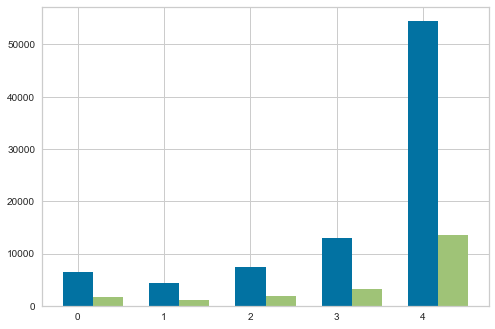

Five Emotions Multiclass Logistics Regression



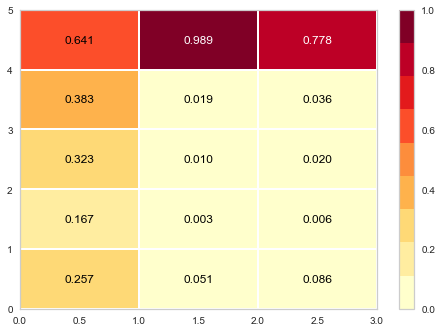

Five Emotions Multiclass KNN



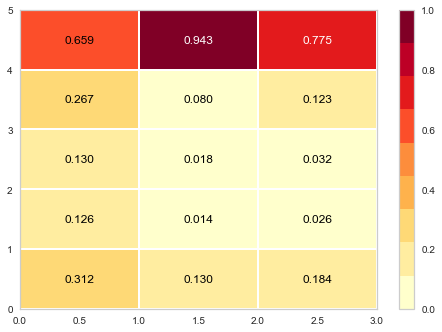

Five Emotions Multiclass Random Forest



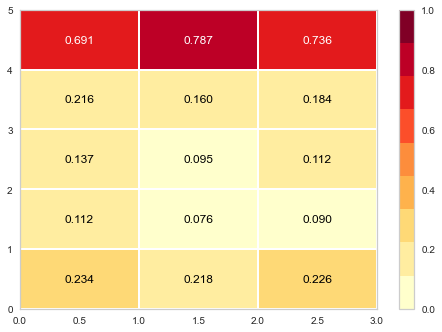

In [41]:
"""
Five Emotions Visualizations for multiclass models
"""

#Class Balance Visualization
CB = ClassBalance()
CB.fit(Y_train, Y_test)
print('Five Emotions Multiclass Class Balance\n')
plt.show()

#Classification Report for Multiple Logistics Regression
MLRC = ClassificationReport(MLR, support=False)
MLRC.fit(X_train, Y_train)      
MLRC.score(X_test, Y_test)
print('Five Emotions Multiclass Logistics Regression\n')
plt.show() 

#Classification Report for KNN
KNNC = ClassificationReport(KNN, support=False)
KNNC.fit(X_train, Y_train)      
KNNC.score(X_test, Y_test)
print('Five Emotions Multiclass KNN\n')
plt.show()

#Classification Report for Random Forest
RFC = ClassificationReport(RF, support=False)
RFC.fit(X_train, Y_train)      
RFC.score(X_test, Y_test)
print('Five Emotions Multiclass Random Forest\n')
plt.show() 

In [42]:
"""
Print out run times to decide how big of a data set to use
"""

ElapsedSeconds = time.time() - StartTime
def convert(seconds):
    seconds = seconds % (24 * 3600)
    hour = seconds // 3600
    seconds %= 3600
    minutes = seconds // 60
    seconds %= 60

    return "%d:%02d:%02d" % (hour, minutes, seconds)
print(convert(ElapsedSeconds))

15:25:24
